# HW5 Fake News Classification

- Author: Skylar Lyu
- Date: March 9, 2023
- HW Instructions: <https://pic16b.quarto.pub/pic-16b-w23/posts/hw5/>

Rampant misinformation—often called “fake news”—is one of the defining features of contemporary democratic life. In this Blog Post, you will develop and assess a fake news classifier using Tensorflow.

*Note: Working on this Blog Post in Google Colab is highly recommended.*

## Data Source

Our data for this assignment comes from the article

*   Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).

I accessed it from [Kaggle](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset). I have done a small amount of data cleaning for you already, and performed a train-test split.

# Instructions

## 1. Acquire Training Data

I have hosted a training data set at the below URL. You can either read it into Python directly (via `pd.read_csv()`) or download it to your computer and read it from disk.

In [1]:
train_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_train.csv?raw=true"

#### Preview Data

In [2]:
import pandas as pd
train_df=pd.read_csv(train_url)
print(train_df.shape)
train_df.head()

(22449, 4)


,Unnamed: 0,title,text,fake
0,17366,Merkel: Strong result for Austria's FPO 'big c...,German Chancellor Angela Merkel said on Monday...,0
1,5634,Trump says Pence will lead voter fraud panel,"WEST PALM BEACH, Fla.President Donald Trump sa...",0
2,17487,JUST IN: SUSPECTED LEAKER and “Close Confidant...,"On December 5, 2017, Circa s Sara Carter warne...",1
3,12217,Thyssenkrupp has offered help to Argentina ove...,"Germany s Thyssenkrupp, has offered assistance...",0
4,5535,Trump say appeals court decision on travel ban...,President Donald Trump on Thursday called the ...,0


Each row of the data corresponds to an article. The `title` column gives the title of the article, while the `text` column gives the full article text. The final column, called `fake`, is `0` if the article is true and `1` if the article contains fake news, as determined by the authors of the paper above.

## 2. Make a Dataset

Write a function called `make_dataset`. This function should do two things:

1. **Remove stopwords from the article `text` and `title`.** A stopword is a word that is usually considered to be uninformative, such as “the,” “and,” or “but.” You may find [this StackOverFlow thread](https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe) to be helpful.

2. **Construct and return a `tf.data.Dataset` with two inputs and one output**. The input should be of the form `(title, text)`, and the output should consist only of the `fake` column. You may find it helpful to consult lecture notes or [this tutorial](https://www.tensorflow.org/guide/keras/functional) for reference on how to construct and use `Dataset`s with multiple inputs.

In [3]:
#compile stopwords
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

import tensorflow as tf

def make_dataset(df):

  #1. remove stopwords from the article text and title
  df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

  #2. construct and return a tf.data.Dataset with two inputs and one output
  Dataset = tf.data.Dataset.from_tensor_slices(
   ( # dictionary for input data/features
       { 
        "title": df[["title"]],
        "text": df[["text"]]
    },
    # dictionary for output data/labels
    { 
        "fake": df[["fake"]]
    }   
   ) 
)

  # batch data to train model on data chunks instead of individual rows
  return Dataset.batch(100)

Call the function `make_dataset` on your training dataframe to produce a `Dataset`. You may wish to `batch` your `Dataset` prior to returning it, which can be done like this: `my_data_set.batch(100)`. Batching causes your model to train on chunks of data rather than individual rows. This can sometimes reduce accuracy, but can also greatly increase the speed of training. Finding a balance is key. I found batches of 100 rows to work well.

In [4]:
#call function to produce a dataset
primary_dataset=make_dataset(train_df)

### Validation Data
After you’ve constructed your primary `Dataset`, split of 20% of it to use for validation.

In [5]:
#shuffle data
primary_dataset = primary_dataset.shuffle(buffer_size = len(primary_dataset))

#specify training and validation dataset sizes
train_size = int(0.8*len(primary_dataset))
val_size   = int(0.2*len(primary_dataset))

#split primary_dataset
train = primary_dataset.take(train_size)
val = primary_dataset.skip(train_size).take(val_size)

#see the size of training and validation data
print(len(train), len(val))

180 45


### Base Rate
Recall that the base rate refers to the accuracy of a model that always makes the same guess (for example, such a model might always say “fake news!”). Determine the base rate for this data set by examining the labels on the training set.

In [6]:
#determine base rate for data by examining labels on the training set
print("The base rate for fake news is", round(len(train_df[train_df['fake']==1])/len(train_df)*100,3),"%")

The base rate for fake news is 52.296 %


### TextVectorization
Here is one option:



```
#preparing a text vectorization layer for tf model
size_vocabulary = 2000

def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

title_vectorize_layer = TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))
```



*Specific layer compilations demonstrated in model configuration in Step 3.*

## 3. Create Models
Please use TensorFlow models to offer a perspective on the following question:

> When detecting fake news, is it most effective to focus on only the title of the article, the full text of the article, or both?

To address this question, create **three (3)** TensorFlow models.

1. In the first model, you should use **only the article title** as an input.
2. In the second model, you should use **only the article text** as an input.
3. In the third model, you should use **both the article title and the article text** as input.

Train your models on the training data until they appear to be “fully” trained. Assess and compare their performance. Make sure to include a visualization of the training histories.

You can visualize your models with this code:

```
from tensorflow.keras import utils
utils.plot_model(model)
```

### Notes
- For the first two models, you don’t have to create new `Dataset`s. Instead, just specify the `inputs` to the `keras.Model` appropriately, and TensorFlow will automatically ignore the unused inputs in the `Dataset`.
- The lecture notes and tutorials linked above are likely to be helpful as you are creating your models as well.
- **You will need to use the Functional API, rather than the Sequential API, for this modeling task.**
- When using the Functional API, it is possible to use the same layer in multiple parts of your model; see [this tutorial](https://www.tensorflow.org/guide/keras/functional) for examples. I recommended that you share an embedding layer for both the article `title` and `text` inputs.
- **You may encounter overfitting**, in which case `Dropout` layers can help.

You’re free to be creative when designing your models. If you’re feeling very stuck, start with some of the pipelines for processing text that we’ve seen in lecture, and iterate from there. Please include in your discussion some of the things that you tried and how you determined the models you used.

### Prepare inputs and shared embedding layer

In [7]:
import re
import string
from tensorflow import keras
from tensorflow.keras import layers

size_vocabulary = 2000

#standardize input data by eliminating punctuations
def standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    no_punctuation = tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation),'')
    return no_punctuation 

#convert title column as keras.Input
title_input = keras.Input(
    shape=(1,),
    name = "title", #same name as the dictionary key in the dataset
    dtype = "string"
)

#convert text column as keras.Input
text_input = keras.Input(
    shape=(1,),
    name = "text",
    dtype = "string"
)

#construct a shared embedding layer
shared_embedding=layers.Embedding(size_vocabulary, output_dim=10, name="embedding")

### `Model1`: only the article `title` as an input

In [8]:
#use Functional API rather than Sequential API

#start with the TextVectorization layer
title_vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

#use the title column to adapt the vectorize_layer
title_vectorize_layer.adapt(train.map(lambda x, y: x["title"]))

#compile layers for `title_features`
title_features = title_vectorize_layer(title_input) #apply this "function TextVectorization layer" to title_input
title_features = shared_embedding(title_features) #use the shared embedding on different models
title_features = layers.Dropout(0.2)(title_features) #dropout layer to reduce overfitting
title_features = layers.GlobalAveragePooling1D()(title_features)
title_features = layers.Dropout(0.2)(title_features)
title_features = layers.Dense(32, activation='relu')(title_features)

#specify output for model1
output1 = layers.Dense(2,name="fake")(title_features) 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


#### Build `model1`

In [9]:
model1 = keras.Model(
    inputs = [title_input], #can use (title_input, text_input) too: model will automatically ignore unused input
    outputs = output1
)

model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 title (InputLayer)          [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 500)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 500, 10)           20000     
                                                                 
 dropout (Dropout)           (None, 500, 10)           0         
                                                                 
 global_average_pooling1d (G  (None, 10)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 10)                0     

#### Visualize `model1`

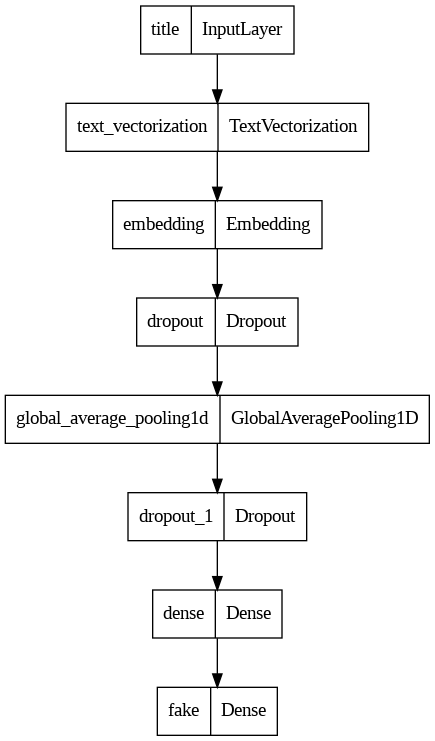

In [10]:
from tensorflow.keras import utils
utils.plot_model(model1)

#### Compile `model1`

In [11]:
from tensorflow.keras import losses

model1.compile(optimizer="adam",
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

#### Train `model1`

In [12]:
history1 = model1.fit(train,
                      validation_data=val,
                      epochs=50,
                      verbose=False) #to prevent printing accuracy scores

/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['text'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


#### Visualize training history for `model1`

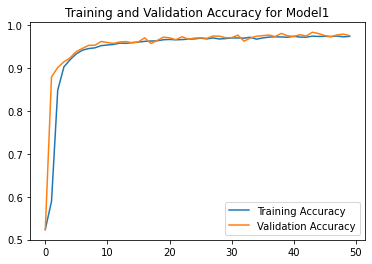

In [13]:
from matplotlib import pyplot as plt
plt.plot(history1.history["accuracy"],label="Training Accuracy")
plt.plot(history1.history["val_accuracy"],label="Validation Accuracy")
plt.title('Training and Validation Accuracy for Model1')
plt.legend()

### `Model2`: only the article `text` as an input

In [14]:
#use Functional API rather than Sequential API

#start with the TextVectorization layer
text_vectorize_layer = layers.TextVectorization(
    standardize=standardization,
    max_tokens=size_vocabulary, # only consider this many words
    output_mode='int',
    output_sequence_length=500) 

#use the text column to adapt the vectorize_layer
text_vectorize_layer.adapt(train.map(lambda x, y: x["text"]))

#compile layers for `text_features`
text_features = text_vectorize_layer(text_input)
text_features = shared_embedding(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.GlobalAveragePooling1D()(text_features)
text_features = layers.Dropout(0.2)(text_features)
text_features = layers.Dense(32, activation='relu')(text_features)

# specify output for model2
output2 = layers.Dense(2,name="fake")(text_features) 

#### Build `model2`

In [15]:
model2 = keras.Model(
    inputs = [text_input], #can use (title_input, text_input) too: model will automatically ignore unused input
    outputs = output2
)

model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 500)              0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 500, 10)           20000     
                                                                 
 dropout_2 (Dropout)         (None, 500, 10)           0         
                                                                 
 global_average_pooling1d_1   (None, 10)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 10)                0   

#### Visualize `model2`

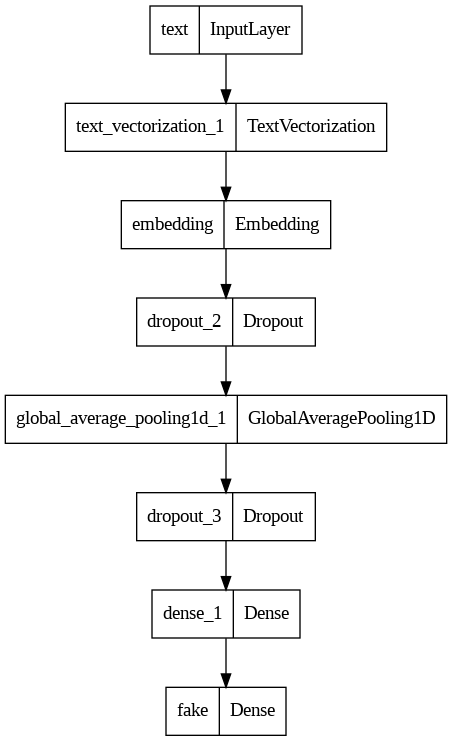

In [16]:
utils.plot_model(model2)

#### Compile `model2`

In [17]:
model2.compile(optimizer="adam",
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

#### Train `model2`

In [18]:
history2 = model2.fit(train,
                      validation_data=val,
                      epochs=50,
                      verbose=False)

/usr/local/lib/python3.9/dist-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['title'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


#### Visualize training history for `model2`

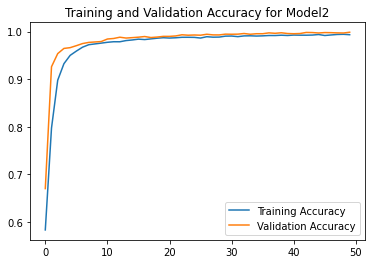

In [19]:
plt.plot(history2.history["accuracy"],label="Training Accuracy")
plt.plot(history2.history["val_accuracy"],label="Validation Accuracy")
plt.title('Training and Validation Accuracy for Model2')
plt.legend()

### `Model3`: **both** the article `title` and the article `text` as input

In [20]:
#combine title and text features
main = layers.concatenate([title_features,text_features], axis = 1)

#apply Dense layer on main
main = layers.Dense(32, activation='relu')(main)

#specify output for model3
output3 = layers.Dense(2,name="fake")(main)

#### Build `model3`

In [21]:
model3 = keras.Model(
    inputs = [title_input,text_input], #both title input and text input
    outputs = output3
)

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 text (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 500)         0           ['title[0][0]']                  
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 500)         0           ['text[0][0]']             

#### Visualize `model3`

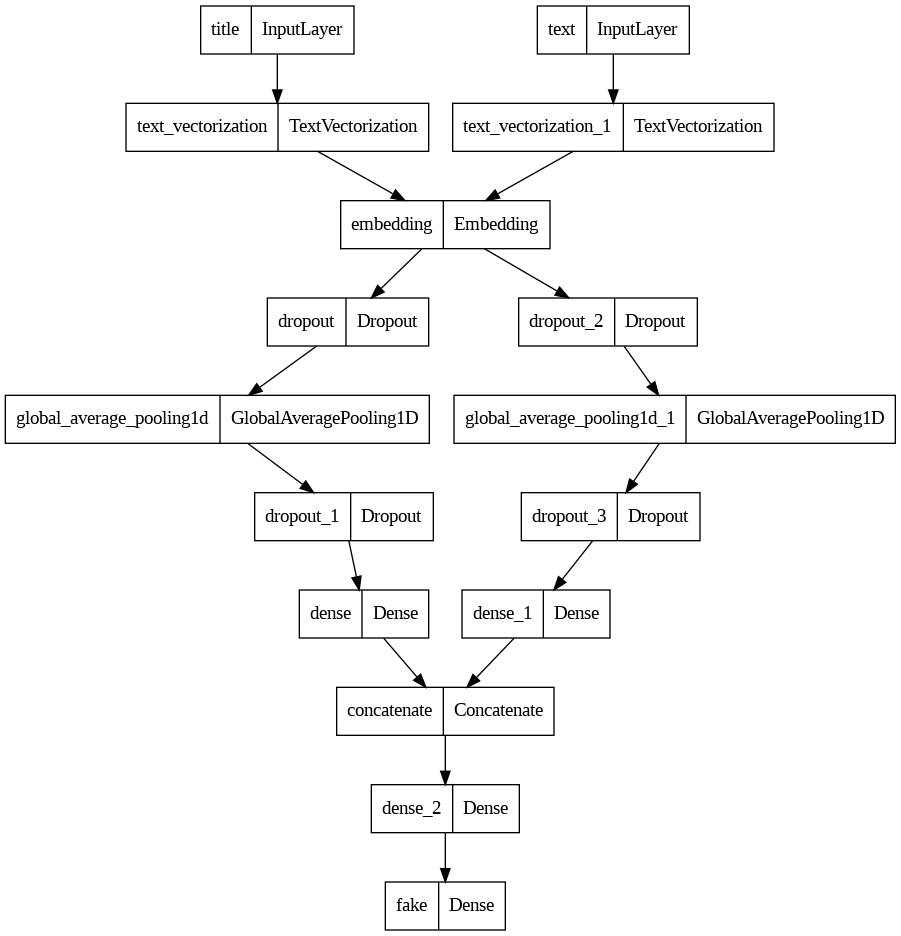

In [22]:
utils.plot_model(model3)

#### Compile `model3`

In [23]:
model3.compile(optimizer="adam",
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

#### Train `model3`

In [24]:
history3 = model3.fit(train,
                      validation_data=val,
                      epochs=50,
                      verbose=False)

#### Visualize training history for `model3`

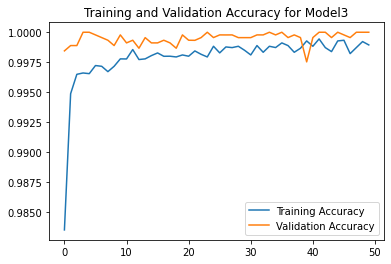

In [25]:
plt.plot(history3.history["accuracy"],label="Training Accuracy")
plt.plot(history3.history["val_accuracy"],label="Validation Accuracy")
plt.title('Training and Validation Accuracy for Model3')
plt.legend()

### What Accuracy Should You Aim For?
Your three different models might have noticeably different performance. **Your best model should be able to consistently score at least 97% validation accuracy.**

After comparing the performance of each model on validation data, make a recommendation regarding the question at the beginning of this section. Should algorithms use the title, the text, or both when seeking to detect fake news?

> Algorithms using both title and text tend to work better at detecting fake news, which has a consistently validation accuracy higher than 98.8%.

## 4. Model Evaluation

Now we’ll test your model performance on unseen test data. For this part, you can focus on your best model, and ignore the other two.

Once you’re satisfied with your best model’s performance on validation data, download the test data here:

In [26]:
test_url = "https://github.com/PhilChodrow/PIC16b/blob/master/datasets/fake_news_test.csv?raw=true"

You’ll need to convert this data using the `make_dataset` function you defined in Part §2. Then, evaluate your model on the data. If we used your model as a fake news detector, how often would we be right?

In [27]:
test_df=pd.read_csv(test_url)
test_dataset=make_dataset(test_df)

loss, accuracy = model3.evaluate(test_dataset)
print('Test accuracy :', accuracy)

225/225 [==============================] - 4s 17ms/step - loss: 0.0474 - accuracy: 0.9907
Test accuracy : 0.9906899929046631


## 5. Embedding Visualization

Visualize and comment on the embedding that your model learned (you did use an embedding, right?). Are you able to find any interesting patterns or associations in the words that the model found useful when distinguishing real news from fake news? You are welcome to use either 2-dimensional or 3-dimensional embedding. Comment on at least 5 words whose location in the embedding you find interpretable.

I’d suggest that you create an embedding in a relatively large number of dimensions (say, 10) and then use PCA to reduce the dimension down to a visualizable number. This procedure was demonstrated in lecture.

In [28]:
weights = model3.get_layer('embedding').get_weights()[0] # get the weights from the embedding layer
vocab = title_vectorize_layer.get_vocabulary()           # get the vocabulary from our data prep for later

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
weights = pca.fit_transform(weights)

embedding_df = pd.DataFrame({
    'word' : vocab, 
    'x0'   : weights[:,0], #weight
    'x1'   : weights[:,1] #bias
}) #need to have the same length for each entry

#### Plot outcome of embedding dataframe

In [33]:
import plotly.express as px 
fig = px.scatter(embedding_df, 
                 x = "x0", 
                 y = "x1",
                 size = [2]*len(embedding_df),
                 hover_name = "word")

fig.show(renderer="notebook")

#### Comment on 5 words whose locations in embedding are interpretable

- `perfect: (8.20,1.22)`: the more the word `perfect` appears, the more highly likely it is fake news; if it doesn't appear at all, however, it is likely that it is fake news too. This suggests that absolute words tends to be overly confident about the performance of its object.

- `doj: (-7.16,-0.41)`: the more the word `doj` appears, the more highly unlikely it is fake news; if it doesn't appear at all, however, it is unlikely that it is fake news either. This is rather intuitive, because the Department of Justice is the government agency with the most credibility in its authority and therefore already guarantees validity if mentioned. 

- `foreign: (9.49,-4.59)`: the more the word `foreign` appears, the more highly likely it is fake news; if it doesn't appear at all, however, it is unlikely that it is fake news. This may be explained by manipulation of information and exaggeration of facts due to xenophobia. 

- `factbox: (3.31,6.18)`: the more the word `factbox` appears, the more  likely it is fake news; if it doesn't appear at all, however, it is likely that it is fake news too. This is ironic because the word itself entails at least fact-based information but it contributes to fake news. 

- `thursday: (-6.53,4.32)`: the more the word `thursday` appears, the more highly unlikely it is fake news; if it doesn't appear at all, however, it is very likely that it is fake news. That is, if a specific time such as `Thursday` was mentioned, it may imply the occurrence of reporting true news; otherwise, it is highly likely to be faked. 